# Imports

In [2]:
# ============================================================================
# 02_preprocessing.ipynb
# Data Preprocessing for Multi-Class Diabetes Classification
# Dataset: BRFSS 2015 - Diabetes Health Indicators (3 Classes)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
sys.path.append('../src/core')

# Import custom modules
from data_loader import load_raw_data
from preprocessing import (
    check_data_quality,
    remove_duplicates,
    create_train_test_split,
    scale_features,
    apply_smote,
    save_processed_data
)

# Plot style
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Define output directory
output_dir = "../outputs/figures/preprocessing"
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created: {output_dir}")

# Define processed data directory
processed_data_dir = "../data/processed"
os.makedirs(processed_data_dir, exist_ok=True)
print(f"Processed data directory created: {processed_data_dir}")


Output directory created: ../outputs/figures/preprocessing
Processed data directory created: ../data/processed


# Loading Data

In [3]:
# =============================================================================
# 1. DATA LOADING
# =============================================================================
print("\n" + "="*80)
print("STEP 1: DATA LOADING")
print("="*80)

df = load_raw_data("../data/raw/diabetes-health-indicators-dataset\diabetes_012_health_indicators_BRFSS2015.csv")

print(f"\nInitial Dataset Shape: {df.shape}")
print(f"Total Samples: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1] - 1}")



STEP 1: DATA LOADING
Data loaded: 253680 rows, 22 columns

Initial Dataset Shape: (253680, 22)
Total Samples: 253,680
Total Features: 21


# Data Quality Check

In [4]:
# =============================================================================
# 2. DATA QUALITY CHECK
# =============================================================================
print("\n" + "="*80)
print("STEP 2: DATA QUALITY CHECK")
print("="*80)

quality_report = check_data_quality(df)

print("\nData Quality Report:")
print("-" * 60)
print(f"Missing Values:  {quality_report['missing_values']}")
print(f"Duplicates:      {quality_report['duplicates']:,}")
print(f"Dataset Shape:   {quality_report['shape']}")




STEP 2: DATA QUALITY CHECK

Data Quality Report:
------------------------------------------------------------
Missing Values:  0
Duplicates:      23,899
Dataset Shape:   (253680, 22)


# Duplicate Removal


STEP 3: REMOVE DUPLICATES

Before removing duplicates: 253,680 samples
Duplicates removed: 23899
After removing duplicates:  229,781 samples


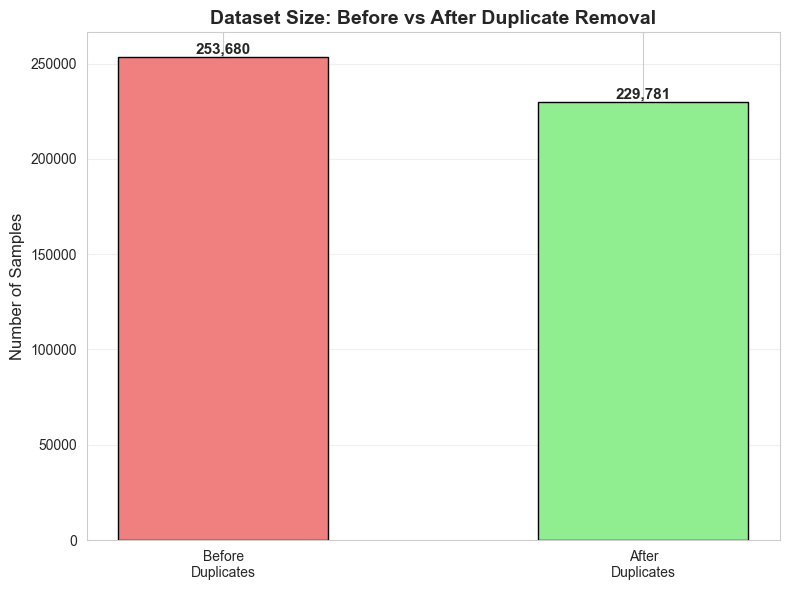


Saved: ../outputs/figures/preprocessing/01_duplicate_removal.png


In [5]:
# =============================================================================
# 3. REMOVE DUPLICATES
# =============================================================================
print("\n" + "="*80)
print("STEP 3: REMOVE DUPLICATES")
print("="*80)

print(f"\nBefore removing duplicates: {df.shape[0]:,} samples")
df_clean = remove_duplicates(df)
print(f"After removing duplicates:  {df_clean.shape[0]:,} samples")

# Visualize duplicate removal
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
categories = ['Before\nDuplicates', 'After\nDuplicates']
counts = [df.shape[0], df_clean.shape[0]]
colors = ['lightcoral', 'lightgreen']

bars = ax.bar(categories, counts, color=colors, edgecolor='black', width=0.5)
ax.set_title('Dataset Size: Before vs After Duplicate Removal', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{output_dir}/01_duplicate_removal.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {output_dir}/01_duplicate_removal.png")


# Separate Features and Target

In [6]:
# =============================================================================
# 4. SEPARATE FEATURES AND TARGET
# =============================================================================
print("\n" + "="*80)
print("STEP 4: SEPARATE FEATURES AND TARGET")
print("="*80)

target_variable = 'Diabetes_012'
features = df_clean.drop(columns=[target_variable])
target = df_clean[target_variable]

print(f"\nFeatures Shape: {features.shape}")
print(f"Target Shape:   {target.shape}")

print("\nTarget Distribution:")
print("-" * 60)
target_counts = target.value_counts().sort_index()
target_percentages = target.value_counts(normalize=True).sort_index() * 100

label_mapping = {0: 'No Diabetes', 1: 'Prediabetes', 2: 'Diabetes'}

for cls in sorted(target.unique()):
    print(f"Class {cls} ({label_mapping[cls]:12s}): "
          f"{target_counts[cls]:7,} ({target_percentages[cls]:5.2f}%)")
    



STEP 4: SEPARATE FEATURES AND TARGET

Features Shape: (229781, 21)
Target Shape:   (229781,)

Target Distribution:
------------------------------------------------------------
Class 0.0 (No Diabetes ): 190,055 (82.71%)
Class 1.0 (Prediabetes ):   4,629 ( 2.01%)
Class 2.0 (Diabetes    ):  35,097 (15.27%)


# Train-Test Split


STEP 5: TRAIN-TEST SPLIT (80/20)
Training Set: 183824 Samples
Test Set: 45957 Samples

Training Set Distribution:
Diabetes_012
0.0    152043
1.0      3703
2.0     28078
Name: count, dtype: int64

Test Set Distribution:
Diabetes_012
0.0    38012
1.0      926
2.0     7019
Name: count, dtype: int64


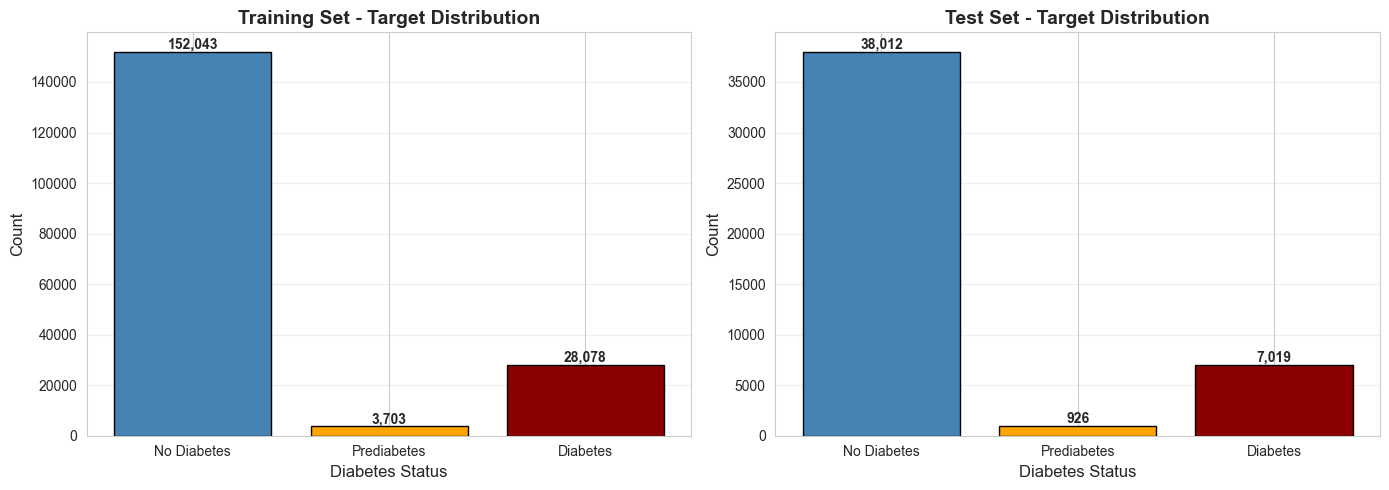


Saved: ../outputs/figures/preprocessing/02_train_test_split.png


In [8]:
# =============================================================================
# 5. TRAIN-TEST SPLIT
# =============================================================================
print("\n" + "="*80)
print("STEP 5: TRAIN-TEST SPLIT (80/20)")
print("="*80)

features_train, features_test, target_train, target_test = create_train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Visualize train-test split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train set distribution
train_counts = target_train.value_counts().sort_index()
axes[0].bar([label_mapping[i] for i in train_counts.index], train_counts.values,
            color=['steelblue', 'orange', 'darkred'], edgecolor='black')
axes[0].set_title('Training Set - Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diabetes Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(train_counts.items()):
    axes[0].text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Test set distribution
test_counts = target_test.value_counts().sort_index()
axes[1].bar([label_mapping[i] for i in test_counts.index], test_counts.values,
            color=['steelblue', 'orange', 'darkred'], edgecolor='black')
axes[1].set_title('Test Set - Target Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Diabetes Status', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
for i, (idx, val) in enumerate(test_counts.items()):
    axes[1].text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{output_dir}/02_train_test_split.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: {output_dir}/02_train_test_split.png")
